In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression

from sklearn import metrics, svm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

import xgboost as xgb

from catboost import CatBoostClassifier, Pool

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [502]:
data = pd.read_csv("/home/andrija/Desktop/customer_complaints/notebooks/processed_data_label.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)

## Further Feature Engineering

In [503]:
data.drop(columns=['Company public response', 'Timely response?', 'Tags', 'Consumer complaint narrative',
                   'Day sent to company'], inplace=True)

## Predictor Separation

In [504]:
y = data['Consumer disputed?'].copy()
X = data.drop(['Consumer disputed?'], axis=1).copy()
columns = X.columns

## OneHotEncoding of Product

In [505]:
# encode = X[['Product', 'State']]
# enc = OneHotEncoder(categories='auto', sparse=False)

# prod_enc = pd.DataFrame(enc.fit_transform(encode))

In [506]:
# X.drop(columns=['Product', 'State'], axis=0, inplace=True)

In [507]:
# X = pd.concat([X, prod_enc], axis=1)

## PCA

In [508]:
# pca = PCA(.95)
# principals = pca.fit_transform(X)
# X = pd.DataFrame(data=principals)

## Train/Test Split

In [509]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

## TomekLinks Undersampling

In [510]:
# %%time

# tl = TomekLinks(sampling_strategy='majority', random_state=42)
# X_res, y_res = tl.fit_resample(X_train, y_train)

# X_train, y_train = X_res, y_res
# X_train = pd.DataFrame(data=X_train)

## SMOTE

In [511]:
%%time

os = SMOTE(random_state=42)
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
X_train, y_train = os_data_X, os_data_y

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 243 ms


## ADASYN

In [512]:
# %%time

# ad = ADASYN(random_state=53)
# X_res, y_res = ad.fit_resample(X_train, y_train)

# X_train, y_train = pd.DataFrame(data=X_res), y_res

## Undersampling (the worst performance)

In [513]:
# data_train = pd.concat([X_train, y_train], axis=1)

# data_shuffled = data_train.sample(frac=1, random_state=4)
# disputed = data_shuffled.loc[data_shuffled['Consumer disputed?'] == 1]

# non_disputed = data_shuffled.loc[data_shuffled['Consumer disputed?'] == 0].sample(n=disputed.shape[0],
#                                                                                   random_state=42)
# balanced_data = pd.concat([disputed, non_disputed])

# X_train = balanced_data.drop(['Consumer disputed?'], axis=1)
# y_train = balanced_data['Consumer disputed?'].copy()

## XGBoost

In [514]:
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10,
                              random_state=52, objective="binary:logistic", subsample=1)

In [515]:
%%time
xgb_model.fit(X_train, y_train)

CPU times: user 5.04 s, sys: 0 ns, total: 5.04 s
Wall time: 5.04 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=52,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [516]:
y_pred = xgb_model.predict(X_test)

In [517]:
confusion_matrix(y_test, y_pred)

array([[8284,  112],
       [2280,   63]])

In [518]:
accuracy_score(y_test, y_pred)

0.7772604525561039

In [519]:
roc_auc_score(y_test, y_pred)

0.5067744593944193

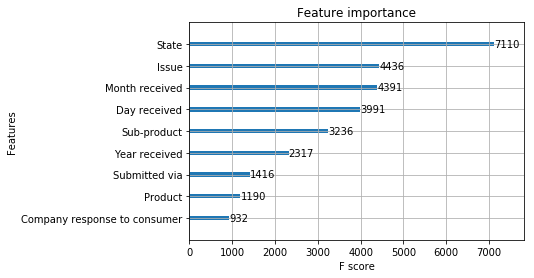

In [520]:
xgb.plot_importance(xgb_model)

In [521]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      8396
           1       0.36      0.03      0.05      2343

    accuracy                           0.78     10739
   macro avg       0.57      0.51      0.46     10739
weighted avg       0.69      0.78      0.69     10739



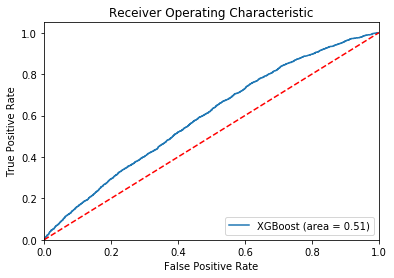

In [522]:
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig('XGBoost_ROC_attempt2')
plt.show()